# TP2 :  Logistic regression for NLP

In [51]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from string import punctuation
from sklearn.model_selection import train_test_split
import torch
from torch import nn

## Dataset

In [52]:
dataset = load_dataset("imdb")
dataset

Found cached dataset imdb (/home/pierre/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [53]:
pd.set_option('display.max_colwidth', 100)
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_unsupervised = pd.DataFrame(dataset['unsupervised'])
labels = df_train["label"].unique()

In [54]:
def preprocessingString(text: str) -> str:
    '''
        Preprocessing string
        Input:
            text: string
        Output:
            text: string
    '''
    text = text.lower().replace("<br />", " ")
    for punct in punctuation:
        if (not punct in str("-")):
            text = text.replace(punct, " ")
    return text

## Extract features 

For every given text, we want to generate a vector with some featues.

- 1 if "no" appears in the document, 0 otherwise.
- The count of first and second pronouns in the document.
- 1 if "!" is in the document, 0 otherwise.
- Log(word count in the document).
- Number of words in the document which are in the positive lexicon.
- Number of words in the document which are in the negative lexicon.

For positive and negative lexicons, you can use the resources provided by VADER sentiment. Look for the vader_lexicon.txt file and consider positive word if they score above a certain threshold (for example 1) and negative word if they score below a certain threshold (for example -1). Feel free to use another lexicon if you find one, but make sure you document your choice.

In [55]:
def parseLexicon(lexiconFile):
    lexicon = {}
    with open(lexiconFile, 'r') as f:
        for line in f:
            word, score = line.split('\t')[:2]
            if float(score) >= 1:
                lexicon[word] = 1
            elif float(score) <= -1:
                lexicon[word] = 0
    return lexicon

lexicon = parseLexicon('vader_lexicon.txt')
lexicon

{'$:': 0,
 '%-)': 0,
 "( '}{' )": 1,
 "('-:": 1,
 "(':": 1,
 '((-:': 1,
 '(*': 1,
 '(-*': 1,
 '(-:': 1,
 '(-:0': 1,
 '(-:o': 1,
 '(-:O': 1,
 '(-:|>*': 1,
 '(-;': 1,
 '(-;|': 1,
 '(8': 1,
 '(:': 1,
 '(:0': 1,
 '(:o': 1,
 '(:O': 1,
 '(;': 1,
 '(=': 1,
 '(?:': 1,
 '(^:': 1,
 '(^;': 1,
 '(^;0': 1,
 '(^;o': 1,
 '(o:': 1,
 ")':": 0,
 ")-':": 0,
 ')-:': 0,
 ')-:<': 0,
 ')-:{': 0,
 '):': 0,
 '):<': 0,
 '):{': 0,
 ');<': 0,
 '*-:': 1,
 '*-;': 1,
 '*:': 1,
 '*<|:-)': 1,
 '*\\0/*': 1,
 '*^:': 1,
 ',-:': 1,
 "---'-;-{@": 1,
 '--<--<@': 1,
 '.-:': 0,
 '..###-:': 0,
 '..###:': 0,
 '/-:': 0,
 '/:': 0,
 '/:<': 0,
 '/^:': 0,
 '/o:': 0,
 '0-|': 0,
 '0:)': 1,
 '0:-)': 1,
 '0:-3': 1,
 '0:03': 1,
 '0;^)': 1,
 '10q': 1,
 '1337': 1,
 '143': 1,
 '1432': 1,
 '14aa41': 1,
 '182': 0,
 '187': 0,
 '2g2b4g': 1,
 '2qt': 1,
 '3:(': 0,
 '3:-(': 0,
 '3:-)': 0,
 '4col': 0,
 '4q': 0,
 '5fs': 1,
 '8)': 1,
 '8-d': 1,
 '86': 0,
 '8d': 1,
 ':###..': 0,
 ":'(": 0,
 ":')": 1,
 ":'-(": 0,
 ":'-)": 1,
 ':(': 0,
 ':)': 1,
 ':*': 

In [56]:
negateWords = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt",
     "ain't", "aren't", "can't", "couldn't", "daren't", "didn't", "doesn't",
     "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt", "neither",
     "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
     "neednt", "needn't", "never", "none", "nope", "nor", "not", "nothing", "nowhere",
     "oughtnt", "shant", "shouldnt", "uhuh", "wasnt", "werent",
     "oughtn't", "shan't", "shouldn't", "uh-uh", "wasn't", "weren't",
     "without", "wont", "wouldnt", "won't", "wouldn't", "rarely", "seldom", "despite"]

def getFeatures(text, lexicon):
    features = []
    features.append(1 if "no" in text else 0)
    features.append(text.count("i") + text.count('you'))
    features.append(1 if "!" in text else 0)
    features.append(math.log(len(text.split())))
    nb_pos = 0
    nb_neg = 0
    nb_negate = 0
    for word in text.split():
        if word in lexicon:
            if lexicon[word] == 1:
                nb_pos += 1
            else:
                nb_neg += 1
        if word in negateWords:
            nb_negate += 1
    features.append(nb_pos)
    features.append(nb_neg)
    #Bonus
    features.append(nb_negate)
    return features

getFeatures("blind date columbia pictures 1934 was a aint decent film but i have a few issues with this film first of all i don t fault the actors in this film at all but more or less i have a problem with the script also i understand that this film was made in the 1930 s and people were looking to escape reality but the script made ann sothern s character look weak she kept going back and forth between suitors and i felt as though she should have stayed with paul kelly s character in the end he truly did care about her and her family and would have done anything for her and he did by giving her up in the end to fickle neil hamilton who in my opinion was only out for a good time paul kelly s character although a workaholic was a man of integrity and truly loved kitty ann sothern as opposed to neil hamilton while he did like her a lot i didn t see the depth of love that he had for her character the production values were great but the script could have used a little work", lexicon)

[0, 58, 0, 5.2832037287379885, 11, 4, 1]

In [57]:
%time getFeatures(df_train['text'][1], lexicon)

CPU times: user 236 µs, sys: 14 µs, total: 250 µs
Wall time: 255 µs


[1, 83, 0, 5.365976015021851, 2, 4, 7]

In [58]:
df_train['text'] = df_train['text'].apply(preprocessingString)
df_test['text'] = df_test['text'].apply(preprocessingString)
df_train

,text,label
0,i rented i am curious-yellow from my video store because of all the controversy that surrounded ...,0
1,i am curious yellow is a risible and pretentious steaming pile it doesn t matter what one s ...,0
2,if only to avoid making this type of film in the future this film is interesting as an experime...,0
3,this film was probably inspired by godard s masculin féminin and i urge you to see that film in...,0
4,oh brother after hearing about this ridiculous film for umpteen years all i can think of is t...,0
...,...,...
24995,a hit at the time but now better categorised as an australian cult film the humour is broad un...,1
24996,i love this movie like no other another time i will try to explain its virtues to the uninitiat...,1
24997,this film and it s sequel barry mckenzie holds his own are the two greatest comedies to ever be...,1
24998,the adventures of barry mckenzie started life as a satirical comic strip in private eye wri...,1


In [59]:
def pandasToFeatures(df):
    arr = df["text"].apply(lambda x : getFeatures(x, lexicon)).values
    index = np.arange(len(df_train['text'].values))
    columns=['contains_no', 'count_pronouns', 'contains!', 'log_wordcount', 'nbr_positive', 'nbr_negative', 'negate_word']
    
    df_features = pd.DataFrame.from_dict(data=dict(zip(index, arr)), orient='index', columns=columns)
    df_features['label'] = df['label']
    return df_features

In [60]:
df_train_features = pandasToFeatures(df_train)
df_test_features = pandasToFeatures(df_train)
df_train_features

,contains_no,count_pronouns,contains!,log_wordcount,nbr_positive,nbr_negative,negate_word,label
0,1,100,0,5.662960,7,6,1,0
1,1,87,0,5.407172,6,4,4,0
2,1,43,0,4.510860,3,3,1,0
3,1,50,0,4.795791,5,5,1,0
4,1,112,0,5.743003,4,11,1,0
...,...,...,...,...,...,...,...,...
24995,1,43,0,4.682131,7,3,0,1
24996,1,72,0,5.220356,8,6,1,1
24997,1,39,0,4.919981,10,3,0,1
24998,1,240,0,6.549651,27,13,5,1


## Logistic regression classifier


In [61]:
train_col = df_train_features.columns[:-1]
all_points = torch.tensor(df_train_features[train_col].values, dtype=torch.float32)
labels = torch.tensor(df_train_features['label'].values, dtype=torch.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    all_points,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42,
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    stratify=y_train,
    random_state=42,
)
print(X_train.shape, X_valid.shape, X_test.shape)
X_train

torch.Size([18000, 7]) torch.Size([2000, 7]) torch.Size([5000, 7])


tensor([[  1.,  81.,   0.,  ...,   8.,  11.,   1.],
        [  0.,  48.,   0.,  ...,   9.,   2.,   0.],
        [  1.,  61.,   0.,  ...,  10.,   3.,   2.],
        ...,
        [  1.,  42.,   0.,  ...,  12.,   0.,   2.],
        [  1., 125.,   0.,  ...,  15.,   6.,   5.],
        [  1.,  49.,   0.,  ...,   3.,  10.,   0.]])

In [62]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

torch.Size([18000, 7]) torch.Size([18000, 1]) torch.Size([2000, 7]) torch.Size([2000, 1])


In [63]:
class LogisticRegression(nn.Module):
    """A logistic regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        output_layer = nn.Sigmoid() if nb_classes == 1 else nn.Softmax()
        self.classifier = torch.nn.Sequential(
            nn.Linear(input_dim, nb_classes),
            output_layer,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of activation function.
        """
        return self.classifier(x)

In [64]:
model = LogisticRegression(7, 1)
criterion = nn.BCELoss()  # Binary cross entropy
# Stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.5)

In [65]:
%%time

def train(model, criterion, optimizer, X_train, y_train, X_valid, y_valid, n_epochs=1000, pretty_print=True):
    # Keeping an eye on the losses
    train_losses = []
    test_losses = []

    # Training loop
    for epoch in range(n_epochs):
        # Setting all gradients to zero.
        optimizer.zero_grad()

        # Sending the whole training set through the model.
        predictions = model(X_train)
        # Computing the loss.
        loss = criterion(predictions, y_train)
        train_losses.append(loss.item())
        if epoch % 100 == 0 and pretty_print:
            print(loss)
        # Computing the gradients and gradient descent.
        loss.backward()
        optimizer.step()

        # When computing the validation loss, we do not want to update the weights.
        # torch.no_grad tells PyTorch to not save the necessary data used for
        # gradient descent.
        with torch.no_grad():
            predictions = model(X_valid)
            loss = criterion(predictions, y_valid)
            test_losses.append(loss)
    return train_losses, test_losses

train_losses, test_losses = train(model, criterion, optimizer, X_train, y_train, X_valid, y_valid, n_epochs=5000)

tensor(2.8974, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7925, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6950, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6416, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6128, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5969, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5879, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5827, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5795, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5776, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5764, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5757, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5753, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5750, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5749, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5749, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5749, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5750, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5751, grad_fn=<Bina

First training loss:  2.897380828857422
Final training loss:  0.5760493874549866
First test loss:  tensor(1.4642)
Final test loss:  tensor(0.5801)
5000 5000


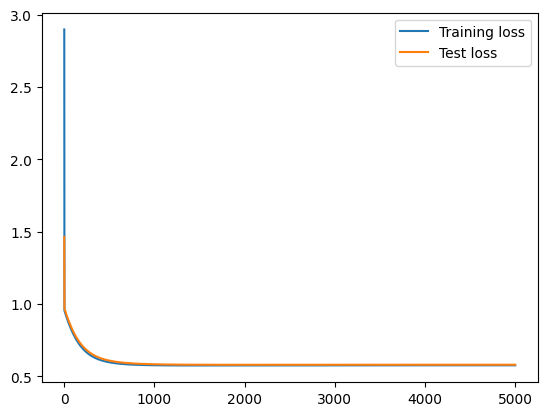

In [66]:
print("First training loss: ", train_losses[0])
print("Final training loss: ", train_losses[-1])
print("First test loss: ", test_losses[0])
print("Final test loss: ", test_losses[-1])
print(len(train_losses), len(test_losses))


# Checking the losses
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()


#### Evaluate your classifier in terms of accuracy for the training, validation, and test set.

In [67]:
# Computing the accuracy for our 3 splits.
with torch.no_grad():
    p_train = model(X_train)
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = model(X_valid)
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = model(X_test)
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(training_accuracy, valid_accuracy, test_accuracy)

0.7266666666666667 0.703 0.713


we can see that the classifier is more accurate than random on all the datasets although it is less accurate than our Naive Bayes Classifier. 
The validation set accuracy and the testing set accuracy are quite close so our model does not overfit a lot

#### Look at the weights of your classifier. Which features seems to play most for both classes?


In [68]:
# Looking at the model's weights and bias.
model.classifier[0].state_dict()["weight"], model.classifier[0].state_dict()["bias"]

(tensor([[ 0.0023,  0.0074, -0.0159, -0.0457,  0.1019, -0.1755, -0.0956]]),
 tensor([-0.0039]))

the key feature used to detect if a sentence is positive is the number of words in the document wich are in the positive lexicon

not so surprisingly the key feature to detect if a sentence is negative is the number of words in the document wich are in the negative lexicon

[Bonus] The parameter weight_decay of the SGD optimizer corresponds to the L2 penalty. Try playing with this value and explain how it influence the model's weights.

In [69]:
# param grid for weight decay
param_grid = {"weight_decay": [0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 100]}
# Grid search
for elt in param_grid["weight_decay"]:
    model_w = LogisticRegression(7, 1)
    criterion_w = nn.BCELoss()  # Binary cross entropy
    optimizer_w = torch.optim.SGD(model_w.parameters(), lr=0.001, weight_decay=elt)
    train_losses, test_losses = train(model_w, criterion_w, optimizer_w, X_train, y_train, X_valid, y_valid, n_epochs=1000, pretty_print=False)
    print("Weight decay: ", elt)
    print(model_w.classifier[0].state_dict()["weight"], model_w.classifier[0].state_dict()["bias"])



Weight decay:  0.01
tensor([[-0.0357,  0.0103, -0.2676, -0.0665,  0.1410, -0.1840, -0.2996]]) tensor([-0.1076])
Weight decay:  0.1
tensor([[ 0.2491,  0.0056,  0.2014, -0.0631,  0.1076, -0.2245,  0.1093]]) tensor([-0.0898])
Weight decay:  0.5
tensor([[-0.0550,  0.0042,  0.0183, -0.0056,  0.0937, -0.1724,  0.0010]]) tensor([0.0156])
Weight decay:  1
tensor([[-0.0340,  0.0050,  0.0984, -0.0174,  0.0926, -0.1496, -0.0538]]) tensor([-0.0903])
Weight decay:  2
tensor([[-0.0484,  0.0070,  0.0243, -0.0116,  0.0754, -0.1303, -0.0230]]) tensor([0.0183])
Weight decay:  5
tensor([[-0.0038, -0.0056,  0.0015, -0.0123,  0.0590, -0.0955, -0.0193]]) tensor([-0.0006])
Weight decay:  10
tensor([[-2.3294e-03, -8.3158e-03, -4.2849e-06, -6.8166e-03,  4.1279e-02,
         -6.4517e-02, -1.0735e-02]]) tensor([-0.0013])
Weight decay:  20
tensor([[-1.0573e-03,  1.1570e-02, -3.6841e-10, -2.6061e-03,  2.7620e-02,
         -3.6591e-02, -5.2267e-03]]) tensor([-0.0005])
Weight decay:  100
tensor([[-3.3155e-04, -1.136

increasing the weight decay parameter let the weights have much more extreme values


#### Take two wrongly classified samples in the test set and try explaining why the model was wrong.

In [94]:
# take wrong predictions and look at them
with torch.no_grad():
    y_pred = df_test['text'].apply(lambda text : (int)(np.round(model(torch.tensor(getFeatures(text, lexicon), dtype=torch.float32)))))
df_wrong_pred = df_test[y_pred != df_test['label']].loc[:, ['text', 'label']]
df_wrong_pred['ai_pred'] = y_pred.loc[y_pred!= df_test['label']]

# take wrong predictions and look at their features
print("feature meaning : [contains_no, count_pronoun, contains!, log_wordcount, nbr_positive, nbr_negative, negate_word	]")
print("feature for example 1 : ", getFeatures(df_wrong_pred.iloc[0]['text'], lexicon))
print("feature for example 2 : ", getFeatures(df_wrong_pred.iloc[-1]['text'], lexicon))
pd.set_option('display.max_colwidth', None)
df_wrong_pred.iloc[[0, -1]]

feature meaning : [contains_no, count_pronoun, contains!, log_wordcount, nbr_positive, nbr_negative, negate_word	]
feature for example 1 :  [1, 40, 0, 4.912654885736052, 12, 2, 4]
feature for example 2 :  [1, 47, 0, 4.882801922586371, 7, 9, 0]


,text,label,ai_pred
4,first off let me say if you haven t enjoyed a van damme movie since bloodsport you probably will not like this movie most of these movies may not have the best plots or best actors but i enjoy these kinds of movies for what they are this movie is much better than any of the movies the other action guys segal and dolph have thought about putting out the past few years van damme is good in the movie the movie is only worth watching to van damme fans it is not as good as wake of death which i highly recommend to anyone of likes van damme or in hell but in my opinion it s worth watching it has the same type of feel to it as nowhere to run good fun stuff,0,1
24999,i caught this movie on the sci-fi channel recently it actually turned out to be pretty decent as far as b-list horror suspense films go two guys one naive and one loud mouthed a take a road trip to stop a wedding but have the worst possible luck when a maniac in a freaky make-shift tank truck hybrid decides to play cat-and-mouse with them things are further complicated when they pick up a ridiculously whorish hitchhiker what makes this film unique is that the combination of comedy and terror actually work in this movie unlike so many others the two guys are likable enough and there are some good chase suspense scenes nice pacing and comic timing make this movie more than passable for the horror slasher buff definitely worth checking out,1,0


Here is two examples where the program should have return a class 0 and 1 (negative, positive).  

the first one is a negative review but our model predicted it was a positive review because there is a lot of positive words in this example like "best" or "like" "better" "good" although they are used in a negative way or to compare to a better movie 

the second one is a positive review but our model predicted it was negative, it is most likely because they are more negative words than positives one in this review, these negative words are used to describe the story not top criticize the movie but the model does not know that



In [71]:
# scikit-learn implementation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Training the model
clf = LogisticRegression(random_state=42, max_iter=5000)
clf.fit(X_train, y_train.ravel())

# Checking the accuracy
y_pred = clf.predict(X_test)

# compare pytorch and scikit-learn accuracy
print("scikit : " ,accuracy_score(y_test, y_pred),"pytorch : ", test_accuracy)


scikit :  0.715 pytorch :  0.713


both implementations seems to have the same results with the same datasets and feature vectors